<a href="https://colab.research.google.com/github/EnterTheBeginning/Machine-Learning/blob/master/HW3_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-Tuning

Now there is a need to Unfreeze some layers in Conv Base network. 

Then Jointly train both layers and the parts that are added

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import os
import zipfile

from keras.layers import Dense,Dropout,Activation,Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import optimizers


Using TensorFlow backend.


##Preprocessing

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
  
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_cat_fnames.sort()
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
#Conv Base VGG19
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

--2019-04-17 21:49:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   204MB/s    in 0.3s    

2019-04-17 21:49:36 (204 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Instructions for updating:
Colocations handled automatically by placer.


##Feature Extraction

In [3]:
##Feature Extractions
%%time
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      directory, target_size=(150, 150),
      batch_size=batch_size,
      class_mode='binary'
  )
  i = 0
  for input_batch, labels_batch in generator:
    features_batch = conv_base.predict(input_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
CPU times: user 16.1 s, sys: 6.05 s, total: 22.2 s
Wall time: 21.2 s


##Freezing the Conv Base

In [15]:
for i,layer in enumerate(conv_base.layers):
    print(i,layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [0]:
conv_base.trainable = False
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Flatten

In [5]:
#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation ='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=2,
                                validation_data=validation_generator,validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
100/100 [==============================] - 23s 230ms/step - loss: 0.6171 - acc: 0.6670 - val_loss: 0.5576 - val_acc: 0.7340
Epoch 2/2
100/100 [==============================] - 22s 225ms/step - loss: 0.5213 - acc: 0.7535 - val_loss: 0.4959 - val_acc: 0.7490


##Unfreezing



Lets fine tune the last **four CNN** layers = all layers above needs to be frozen

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block3_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [8]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])
history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=30,validation_data=validation_generator,validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 28s 279ms/step - loss: 0.3762 - acc: 0.8220 - val_loss: 0.2230 - val_acc: 0.9020
Epoch 2/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2552 - acc: 0.8935 - val_loss: 0.2527 - val_acc: 0.8910
Epoch 3/30
100/100 [==============================] - 24s 243ms/step - loss: 0.2053 - acc: 0.9220 - val_loss: 0.1790 - val_acc: 0.9280
Epoch 4/30
100/100 [==============================] - 25s 253ms/step - loss: 0.1667 - acc: 0.9310 - val_loss: 0.1777 - val_acc: 0.9220
Epoch 5/30
100/100 [==============================] - 24s 244ms/step - loss: 0.1551 - acc: 0.9315 - val_loss: 0.1926 - val_acc: 0.9250
Epoch 6/30
100/100 [==============================] - 24s 242ms/step - loss: 0.1409 - acc: 0.9465 - val_loss: 0.1956 - val_acc: 0.9190
Epoch 7/30
100/100 [==============================] - 25s 251ms/step - loss: 0.1246 - acc: 0.9520 - val_loss: 0.1352 - val_acc: 0.9480
Epoch 8/30
100/100 [==============================] - 2

In [11]:
score= model.evaluate_generator(validation_generator,steps = 50)
print("Loss :",score[0])
print("Accuracy: ",score[1])


Loss : 0.14029728736786637
Accuracy:  0.9579999923706055


Accuracy of **96**%.

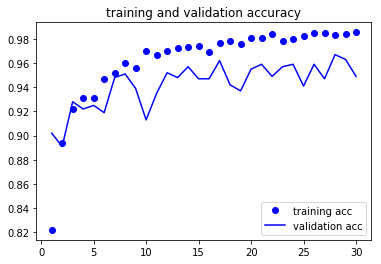

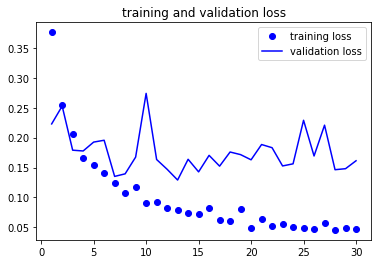

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()
